# Adventures in Covariance

Recall the coffee robot from the introduction to the previous chapter. This robot is programmed to move among cafes, order coffee, and record the waiting time. The previous chapter focused on the fact that the robot learns more efficiently when it pools information among the cafes. Varying intercepts are a mechanism for achieving that pooling. 

Now suppose that the robot also records the time of day, morning or afternoon. The average waiting time in the morning tends to be longer than the average wait time in the afternoon. The average wait time in the morning tends to be longer than the average wait time in the afternoon. This is because cafes are busier in the morning. But just like cafes vary in their average wait time, they also vary in their differences between morning and afternoon. In conventional regression, these differences in wait time between morning and afternoon are slopes, since they express the change in expectation between morning and afternoon. The linear model might look like this:

mu = alpha_cafe + beta_cafe*A*

Since the robot more efficiently learns about the intercepts, alpha_cafe when it pools information about intercepts, it likewise learns more efficiently about the slopes when it also pools information about slopes.

This is the essence of the general VARYING EFFECTS strategy. Any batch of parameters with exchangable index values can and probably should be pooled. There is nothing special about intercepts, slopes can also vary by unit of data, and pooling information among them makes better use of the data. So our coffee robot should be programmed to model both the population of intercepts and the population of slopes. Then it can use pooling for both and squeeze more information out of the data.

But heres a act that will help is to squeeze even more information out of the data. Cafe's covary in their intercepts and slopes. This covariation is information that a robot can use. If we can figure out a way to pool information across parameter types - intercepts and slopes - what the robot learns in the morning can improve learning about afternoons, and vice versa.

In this chapter, youll see how to really do this, to specify VARYING SLOPES in combination with the varying intercepts of the previous chapter. This will enable pooling that wil improve estimates of how different unts respond to or are influenced by predictor variables. It also improves estimates of intercepts, by borrowing information across parameter types

## Varying slopes by construction

Lets start by defining a population of cafes that the robot might visit. This means we'll define the average wait time in the morning and the afternoon, as well as the correlation betwen them. These numbers are sufficient to define the AVERAGE properties of the cafes. Lets define these properties, then we'll sample cafes from them


In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm

from matplotlib.patches import Ellipse, transforms
from scipy import stats
from theano import tensor as tt

In [3]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.ic_scale"] = "deviance"
az.rcParams["stats.information_criterion"] = "waic"

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [4]:
a = 3.5  # average morning wait time
b = -1.0  # average difference afternoon wait time
sigma_a = 1.0  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

These values define the entire population of cafes. To use thes values to simulate a sample of cafes for the robot, we'll need to build them into a 2 dimensional multivarite gaussian distribution.

In [5]:
Mu = [a, b]

In [6]:
cov_ab = sigma_a * sigma_b * rho
Sigma = np.array([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])
Sigma

array([[ 1.  , -0.35],
       [-0.35,  0.25]])

Now we are ready to simulate some cafes, each with its own intercept and slope. Lets define the number of cafes

In [7]:
N_cafes = 20

And to simulate their properties, we just sample randomly from the multivariate gaussian distribution defined by mu and sigma

In [13]:
vary_effects = np.random.multivariate_normal(mean=Mu, cov=Sigma, size=N_cafes)

Look at the contents of VARY_effects now, it should be a matrix with 20 rows and 2 columns. Each row is a cafe. The first column contains intercepts. The second column contains slopes. For transparency, lets split these columns apart into nicely named vectors

In [14]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

In [15]:
def Gauss2d(mu, cov, ci, ax=None):
    """Copied from statsmodel"""
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 6))

    v_, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees

    for level in ci:
        v = 2 * np.sqrt(v_ * stats.chi2.ppf(level, 2))  # get size corresponding to level
        ell = Ellipse(
            mu[:2],
            v[0],
            v[1],
            180 + angle,
            facecolor="None",
            edgecolor="k",
            alpha=(1 - level) * 0.5,
            lw=1.5,
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

    return ax

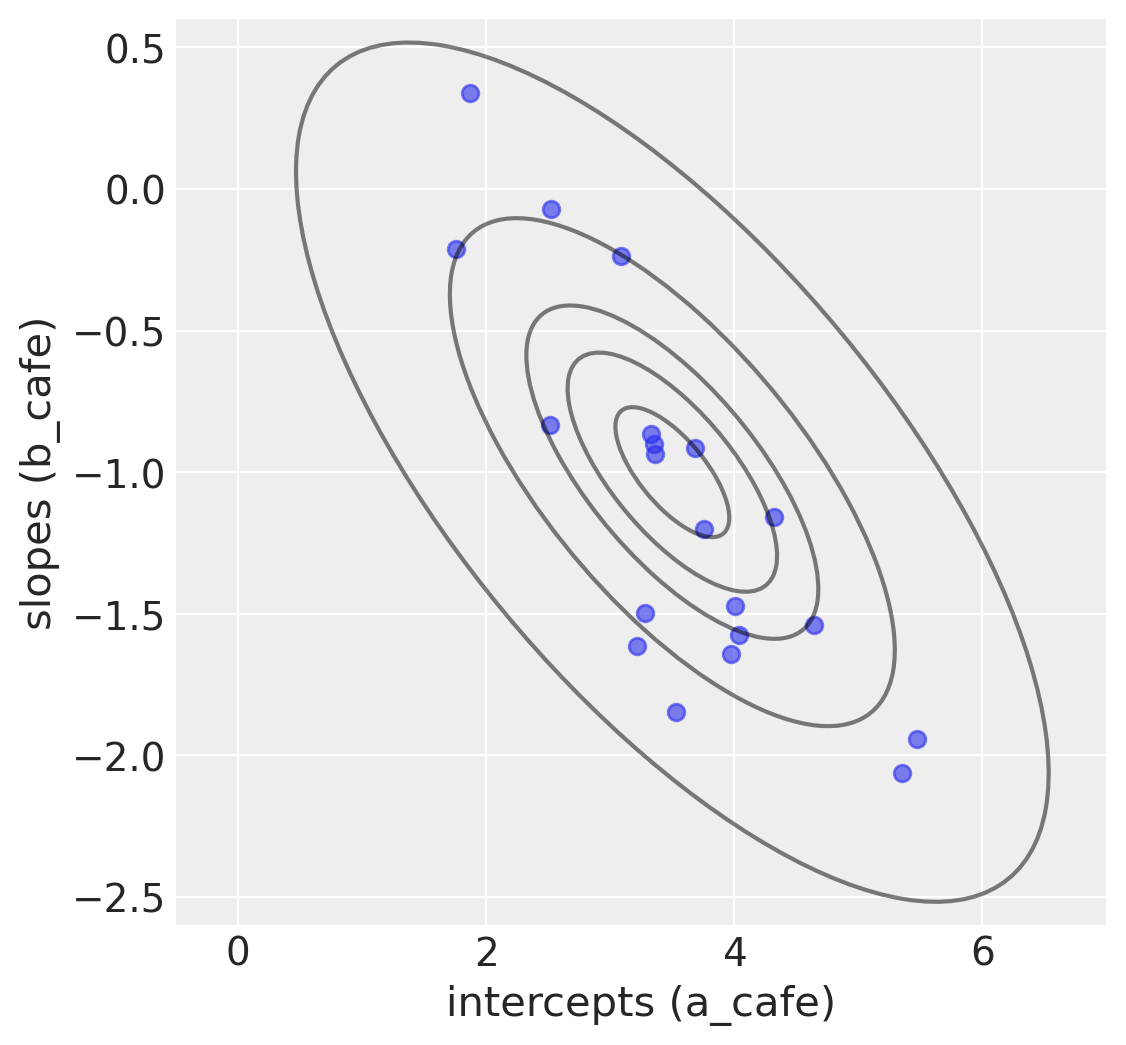

In [16]:
ax = Gauss2d(Mu, np.asarray(Sigma), [0.1, 0.3, 0.5, 0.8, 0.99])
ax.scatter(a_cafe, b_cafe, alpha=0.6)
ax.set_xlim(-0.5, 7)
ax.set_ylim(-2.6, 0.6)
ax.set_xlabel("intercepts (a_cafe)")
ax.set_ylabel("slopes (b_cafe)");

### simulate observations

Were almost cone simulating. What we did above was simulate individual cafes and their average properties. Now all that remains is to simulate our robot visiting these cafes and collecting data. The code below visits 10 visits to each cafe, 5 in the morning and 5 in the afternoon. Then it combines all of the visits into a common datframe

In [17]:
N_visits = 10
afternoon = np.tile([0, 1], N_visits * N_cafes // 2)  # wrap with int() to suppress warnings
cafe_id = np.repeat(np.arange(0, N_cafes), N_visits)  # 1-20 (minus 1 for python indexing)

mu = a_cafe[cafe_id] + b_cafe[cafe_id] * afternoon
sigma = 0.5  # std dev within cafes

wait = np.random.normal(loc=mu, scale=sigma, size=N_visits * N_cafes)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))
d

,cafe,afternoon,wait
0,0,0,5.300726
1,0,1,3.155502
2,0,0,4.241756
3,0,1,3.002125
4,0,0,4.032722
...,...,...,...
195,19,1,1.837032
196,19,0,3.104896
197,19,1,2.004038
198,19,0,3.548053


Go ahead and look inside the dataframe d now. You'll find exactly the sort of data that is well-suited to varying slopes model. There are multiple clusters in the data. These are the cafes. And each cluster is observed under diferent conditions. So its possible to estimate both an invidua intercept for ech cluster, as well as an individual slope.

In this example, everything is balanced. Each cafe has been observed exactly 10 times, and the time of day is always balanced as well, with 5 in the morning and 5 in the afternoon. But in general the data do not need to be balanced. Just like the tadpoles example from the previous chapter, lack of balance can realy favour the varying effects analysis because partial pooling uses information about the population where it is needed most.

RETHINKING - in this exercise, we are simulating data from a generative process and then analysing that data with a model that reflects exactly the correct structure of that process. But in the real world, we're never so lucky. Instead we are always forced to analyse data with a model that is MISSPECIFIED. The true data-generating process is different than the model. Simulation can be used. however to explore the misspecification. Just simulate data from a process